# A simple 2D Flow Matching model

This notebook trains and evaluates a simple 2D FM model with CondOT (i.e., linear) scheduler.

Dataset: 2D checkerboard
Model (velocity): MLP

## Imports and init device

In [1]:
import time
import torch
import numpy as np
from torch import nn, Tensor

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm

from peft import LoraConfig, get_peft_model
from sklearn.datasets import make_moons
import sys
sys.path.append("/home/u5649209/workspace/flow_matching")  # Adjust the path as necessary to import flow_matching_utils
from flow_matching_utils import MLP, evaluate_result

# To avoide meshgrid warning
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='torch')

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')

Using gpu


In [3]:
torch.manual_seed(42)

## Dataset

In [4]:
def inf_train_gen(batch_size: int = 200, device: str = "cpu"):
    x1 = torch.rand(batch_size, device=device) * 4 - 2
    x2_ = torch.rand(batch_size, device=device) - torch.randint(high=2, size=(batch_size, ), device=device) * 2
    x2 = x2_ + (torch.floor(x1) % 2)

    data = 1.0 * torch.cat([x1[:, None], x2[:, None]], dim=1) / 0.45
    
    return data.float()
import numpy as np
from flow_matching_utils import train_moon_gen
from flow_matching_utils import reinit_lora



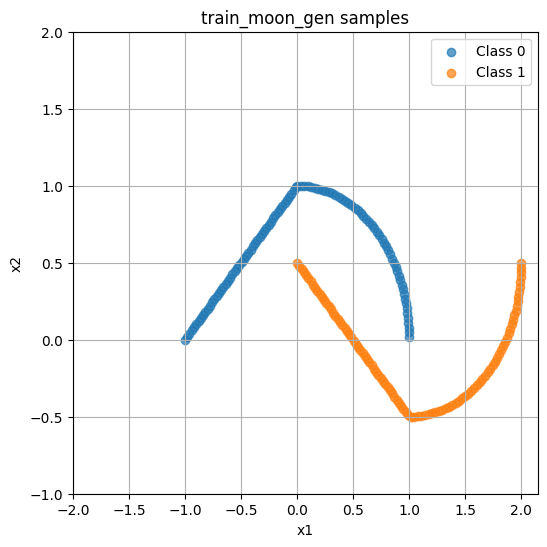

In [5]:
x, y = train_moon_gen(batch_size=200, device=device, is_pretrain=False, mode="new")
plt.figure(figsize=(6, 6))
for label in [0, 1]:
    plt.scatter(x[y == label, 0], x[y == label, 1], label=f'Class {label}', alpha=0.7)
plt.xticks(np.arange(-2, 2.5, 0.5))
plt.yticks(np.arange(-1, 2.5, 0.5))
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('train_moon_gen samples')
plt.legend()
plt.grid(True)
plt.show()

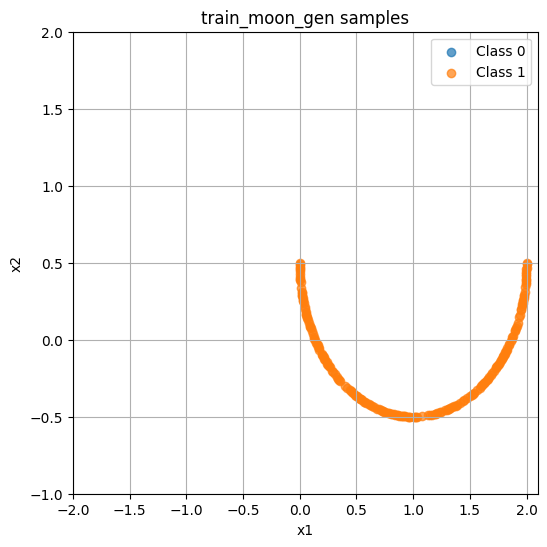

In [6]:
x, y = train_moon_gen(batch_size=200, device=device, is_pretrain=False, mode="raw")
plt.figure(figsize=(6, 6))
for label in [0, 1]:
    plt.scatter(x[y == label, 0], x[y == label, 1], label=f'Class {label}', alpha=0.7)
plt.xticks(np.arange(-2, 2.5, 0.5))
plt.yticks(np.arange(-1, 2.5, 0.5))
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('train_moon_gen samples')
plt.legend()
plt.grid(True)
plt.show()

## Train Velocity Flow Matching model

In [7]:
import os

# training arguments
lr = 0.001
batch_size = 4096
iterations = 10000
print_every = 1 
hidden_dim = 512
is_pre_train = False
is_lora = True
is_eval = True
is_reinit = True
mode = "new"
# velocity field model init
if not is_eval:
    vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device) 

    # instantiate an affine path object
    path = AffineProbPath(scheduler=CondOTScheduler())
    if not is_pre_train:
        state_dict = torch.load(f"/home/u5649209/workspace/flow_matching/ckpts/weights/raw_model_19999.pth", map_location=device)
        vf.load_state_dict(state_dict)
        if is_lora:
            if is_reinit:
                # reinit the model
                import pickle
                vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
                vf.load_state_dict(torch.load(f"/home/u5649209/workspace/flow_matching/ckpts/weights/raw_model_19999.pth", map_location=device))
                lora_config = LoraConfig(
                    r=2,
                    lora_alpha=4,
                    target_modules=["main.0", "main.2", "main.4", "main.6"],  # target Linear layers in MLP
                    init_lora_weights="gaussian",
                )
                vf = get_peft_model(vf, lora_config)
                gamma = 9
                # with open(f'/home/u5649209/workspace/flow_matching/ckpts/raw_model_gradients/models_grads_step19999_new.pkl', 'rb') as f:
                with open(f'/home/u5649209/workspace/flow_matching/ckpts/raw_model_gradients/fullP_step1_new.pkl', 'rb') as f:  # IGNORE
                    named_grad = pickle.load(f)
                _ = reinit_lora(vf, gamma, named_grad, init_mode = "lora-one")
            else:
                lora_config = LoraConfig(
                r=2,
                lora_alpha=4,
                target_modules=["main.0", "main.2", "main.4", "main.6", "main.8"],  # target Linear layers in MLP
                )
                vf = get_peft_model(vf, lora_config)
                # init optimizer (only optimize LoRA parameters)
            optim = torch.optim.Adam(vf.parameters(), lr=lr)
            optim.param_groups[0]['params'] = [p for n, p in vf.named_parameters() if 'lora_' in n]
        else:
            # init optimizer (optimize all parameters)
            optim = torch.optim.Adam(vf.parameters(), lr=lr)
        iterations = 10000  # set iterations to 10000 for LoRA training
        print_every = 2000
    else:
        # init optimizer (optimize all parameters)
        optim = torch.optim.Adam(vf.parameters(), lr=lr)


    # train
    start_time = time.time()
    loss_history = []
    for i in range(iterations):
        optim.zero_grad() 
        
        # sample data (user's responsibility): in this case, (X_0,X_1) ~ pi(X_0,X_1) = N(X_0|0,I)q(X_1)
        x_1, y = train_moon_gen(batch_size=batch_size, device=device, is_pretrain=is_pre_train, mode = mode) # sample data
        # print(y)
        x_1 = torch.tensor(x_1).float().to(device)
        x_0 = torch.randn_like(x_1).to(device)

        # x_0, y = make_moons(n_samples=x_1.shape[0] * 3, noise=0.5, random_state=42)
        # if is_pre_train:
        #     x_0 = torch.tensor(x_0[y == 0][:x_1.shape[0]]).float().to(device)  # use only one class for pre-training
        # else:
        #     x_0 = torch.tensor(x_0[y == 1][:x_1.shape[0]]).float().to(device)

        # sample time (user's responsibility)
        t = torch.rand(x_1.shape[0]).to(device)
        

        # sample probability path
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)

        # flow matching l2 loss
        loss = torch.pow(vf(path_sample.x_t,path_sample.t) - path_sample.dx_t, 2).mean() 
        loss_history.append(loss.item())
        # optimizer step
        loss.backward() # backward
        optim.step() # update
        if i == 2:
            if not is_pre_train:
                if is_lora:
                    if is_reinit:
                        save_path = f"/home/u5649209/workspace/flow_matching/ckpts/weights/lora_one_{i+1}_{mode}"
                        os.makedirs(save_path, exist_ok=True)
                        vf.save_pretrained(save_path)
                    else:
                        save_path = f"/home/u5649209/workspace/flow_matching/ckpts/weights/lora_weights_{i+1}_{mode}"
                        os.makedirs(save_path, exist_ok=True)
                        vf.save_pretrained(save_path)
                else:
                    save_path = f"/home/u5649209/workspace/flow_matching/ckpts/weights/full_model_{i}_{mode}.pth"
                    if not os.path.exists(os.path.dirname(save_path)):
                        os.makedirs(os.path.dirname(save_path), exist_ok=True)
                    torch.save(vf.state_dict(), save_path)
            else:
                save_path = f"/home/u5649209/workspace/flow_matching/ckpts/weights/raw_model_{i}.pth"
                if not os.path.exists(os.path.dirname(save_path)):
                    os.makedirs(os.path.dirname(save_path), exist_ok=True)
                torch.save(vf.state_dict(), save_path)
        # log loss
        if (i+1) % print_every == 0:
            elapsed = time.time() - start_time
            print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} ' 
                .format(i+1, elapsed*1000/print_every, loss.item())) 
            start_time = time.time()
            if not is_pre_train:
                if is_lora:
                    if is_reinit:
                        save_path = f"/home/u5649209/workspace/flow_matching/ckpts/weights/lora_one_{i+1}_{mode}"
                        os.makedirs(save_path, exist_ok=True)
                        vf.save_pretrained(save_path)
                    else:
                        save_path = f"/home/u5649209/workspace/flow_matching/ckpts/weights/lora_weights_{i+1}_{mode}"
                        os.makedirs(save_path, exist_ok=True)
                        vf.save_pretrained(save_path)
                else:
                    save_path = f"/home/u5649209/workspace/flow_matching/ckpts/weights/full_model_{i}_{mode}.pth"
                    if not os.path.exists(os.path.dirname(save_path)):
                        os.makedirs(os.path.dirname(save_path), exist_ok=True)
                    torch.save(vf.state_dict(), save_path)
            else:
                save_path = f"/home/u5649209/workspace/flow_matching/ckpts/weights/raw_model_{i}.pth"
                if not os.path.exists(os.path.dirname(save_path)):
                    os.makedirs(os.path.dirname(save_path), exist_ok=True)
                torch.save(vf.state_dict(), save_path)


In [8]:
if not is_eval:
    plt.figure(figsize=(8, 4))
    plt.plot(loss_history[:])
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.grid(True)
    plt.show()

In [ ]:

import pickle
from peft import LoraConfig, get_peft_model, PeftModel
path = "/home/u5649209/workspace/flow_matching/ckpts/weights/lora_one_3_new"
if is_eval:
    # load the model
    if is_lora:
        vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
        vf.load_state_dict(torch.load("/home/u5649209/workspace/flow_matching/ckpts/weights/raw_model_19999.pth", map_location=device))
        vf = PeftModel.from_pretrained(vf, path)
    else:
        vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
        vf.load_state_dict(torch.load(path, map_location=device))
    # else:
    #     # reinit the model
    #     vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
    #     vf.load_state_dict(torch.load(f"/home/u5649209/workspace/flow_matching/ckpts/weights/raw_model_19999.pth", map_location=device))
    #     lora_config = LoraConfig(
    #         r=2,
    #         lora_alpha=4,
    #         target_modules=["main.0", "main.2", "main.4", "main.6"],  # target Linear layers in MLP
    #         init_lora_weights="gaussian",
    #     )
    #     vf = get_peft_model(vf, lora_config)
    #     gamma = 9
    #     # with open(f'/home/u5649209/workspace/flow_matching/ckpts/raw_model_gradients/models_grads_step19999_new.pkl', 'rb') as f:
    #     with open(f'/home/u5649209/workspace/flow_matching/ckpts/raw_model_gradients/fullP_step1_new.pkl', 'rb') as f:  # IGNORE
    #         named_grad = pickle.load(f)
    #     _ = reinit_lora(vf, gamma, named_grad, init_mode = "lora-one")
    

#### Sample from trained model

In [10]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)

wrapped_vf = WrappedModel(vf)

In [11]:
# step size for ode solver
step_size = 0.05

norm = cm.colors.Normalize(vmax=50, vmin=0)

batch_size = 50000  # batch size
eps_time = 1e-2
T = torch.linspace(0,1,10)  # sample times
T = T.to(device=device)

x_init = torch.randn((batch_size, 2), dtype=torch.float32, device=device)
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)  # sample from the model

### Visualize the path

[[ 0.26890275  0.9938839 ]
 [ 0.20214194  0.9722179 ]
 [-0.67900395  0.35428095]
 ...
 [ 0.12297245  0.9871411 ]
 [ 0.46261388  0.01550732]
 [ 0.12406094  0.35431343]]


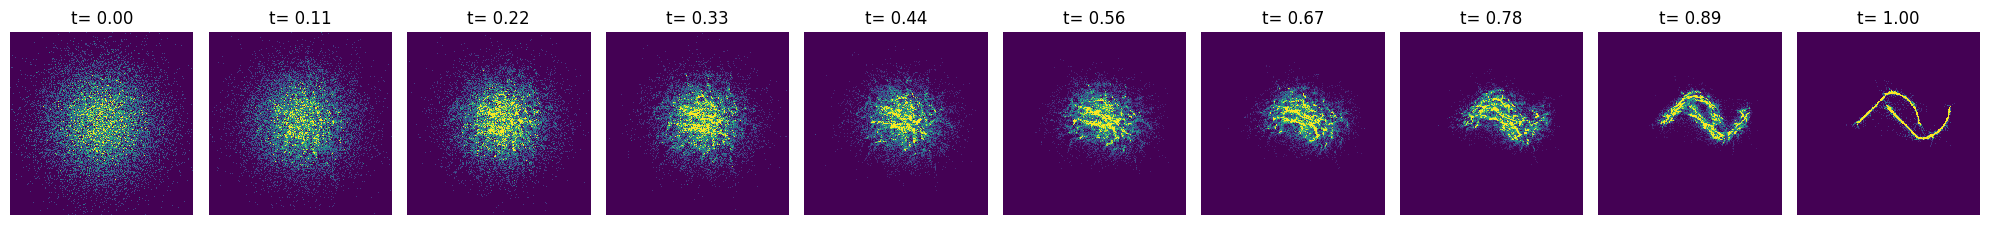

In [12]:
sol = sol.cpu().numpy()
T = T.cpu()

fig, axs = plt.subplots(1, 10,figsize=(20,20))
print(sol[9, :, :2])
for i in range(10):
    H= axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-3,3), (-3,3)))
    
    cmin = 0.0
    cmax = torch.quantile(torch.from_numpy(H[0]), 0.99).item()
    
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    
    _ = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-3,3), (-3,3)), norm=norm)
    
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].set_title('t= %.2f' % (T[i]))
    
plt.tight_layout()
plt.show()

## Compute and Visualize Model Log-likelihood

torch.Size([40000, 2])


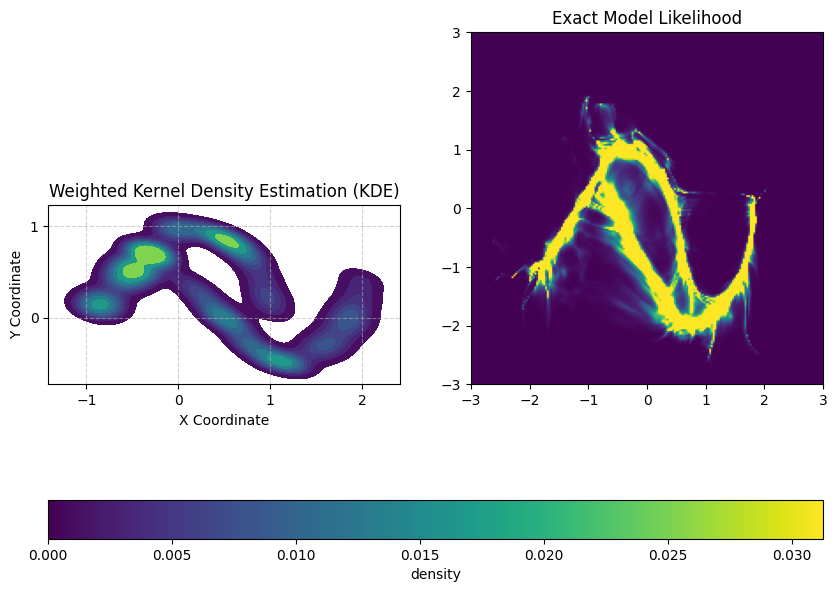

Load Model From: /home/u5649209/workspace/flow_matching/ckpts/weights/lora_one_2000_new, Likelihood: 0.42409834265708923, Exact NLL: 0.2743479311466217


In [13]:
nll, exact_nll = evaluate_result(vf, data_mode=mode)
print(f"Load Model From: {path}, Likelihood: {nll}, Exact NLL: {exact_nll}")

In [14]:
from torch.distributions import Independent, Normal

In [15]:
# sample with likelihood

T = torch.tensor([1., 0.])  # sample times
T = T.to(device=device)

grid_size = 200
x_1 = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
x_1 = torch.stack([x_1[0].flatten(), x_1[1].flatten()], dim=1).to(device)
print(x_1.shape)

torch.Size([40000, 2])
